In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# boston = pd.read_csv('github.com/pararawendy/dibimbing-materials/blob/main/boston.csv')
# boston.head()

In [ ]:
# Load Data
boston = pd.read_csv('Boston.csv')
boston.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# Split train test
from sklearn.model_selection import train_test_split

feature = boston.drop(columns='medv')
target = boston[['medv']]

feature_medv_train, feature_medv_test, target_medv_train, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [ ]:
# Calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,Unnamed: 0,2.128233
2,crim,1.713232
3,zn,2.488125
4,indus,3.882014
5,chas,1.097136
6,nox,4.477550
7,rm,1.957812
8,age,3.135556
9,dis,4.200039
10,rad,8.245190


Beberapa feature dengan Vif Score yang Tinggi:
1. tax
2. rad
3. dis
4. nox
5. indus
6. age

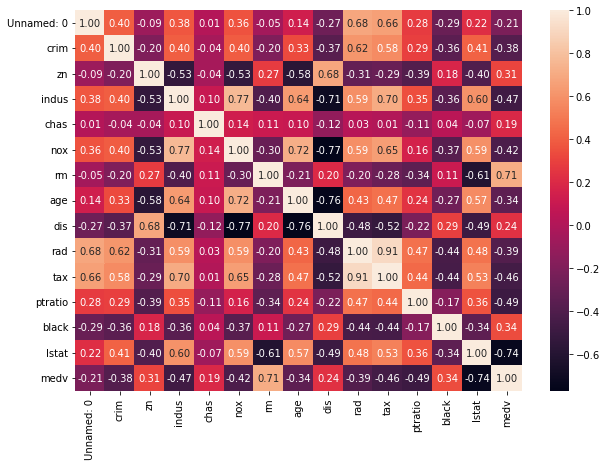

In [ ]:
# Heatmap correlation
medv_train = pd.concat([feature_medv_train, target_medv_train], axis=1)
corr = medv_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Saya mempertahankan Istat, karena mempunyai korelasi tertinggi terhadap medv,, dan menghapus feature yang mempunyai Vif tinggi

In [ ]:
# drop redundant features
feature_medv_train = feature_medv_train.drop(columns=['nox', 'dis', 'rad', 'tax'])
feature_medv_test = feature_medv_test.drop(columns=['nox', 'dis', 'rad', 'tax'])

In [ ]:
# Melakukan pengecekan kembali terhadap Vif
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,Unnamed: 0,1.432763
2,crim,1.469438
3,zn,1.792246
4,indus,2.569993
5,chas,1.072859
6,rm,1.884055
7,age,2.390291
8,ptratio,1.408034
9,black,1.283071
10,lstat,2.744700


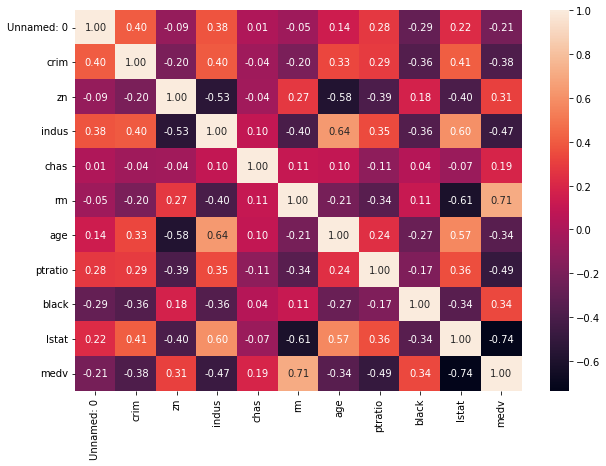

In [ ]:
medv_train = pd.concat([feature_medv_train, target_medv_train], axis=1)
corr = medv_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

## MODEL TRAINING

### Ridge

In [ ]:
from sklearn.linear_model import Ridge

# train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

# define the model
ridge_reg = Ridge(alpha=0.1, 
                  random_state=42)

ridge_reg.fit(X_medv_train, y_medv_train)

Ridge(alpha=0.1, random_state=42)

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_medv_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,6.744628
1,Unnamed: 0,-0.000375
2,crim,-0.058157
3,zn,-0.013961
4,indus,0.019134
5,chas,3.042269
6,rm,5.109110
7,age,0.009623
8,ptratio,-0.805990
9,black,0.012368


## Lasso

In [ ]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=0.1, 
                  random_state=42)

lasso_reg.fit(X_medv_train, y_medv_train)

Lasso(alpha=0.1, random_state=42)

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_medv_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,8.850755
1,Unnamed: 0,-0.000129
2,crim,-0.058976
3,zn,-0.012852
4,indus,0.017297
5,chas,1.538988
6,rm,4.819733
7,age,0.014064
8,ptratio,-0.817075
9,black,0.012383


Choosing Best Lambda

Train Validation test

In [ ]:
# split train test
from sklearn.model_selection import train_test_split

feature = boston.drop(columns='medv')
target = boston[['medv']]

# First splitting: pretrain and test
feature_medv_pretrain, feature_medv_test, target_medv_pretrain, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_medv_train, feature_medv_validation, target_medv_train, target_medv_validation = train_test_split(feature_medv_pretrain, target_medv_pretrain, test_size=0.20, random_state=42)

Drop Multicollinear Features

In [ ]:
feature_medv_train = feature_medv_train.drop(columns=['nox', 'dis', 'rad', 'tax'])
feature_medv_validation = feature_medv_validation.drop(columns=['nox', 'dis', 'rad','tax'])
feature_medv_test = feature_medv_test.drop(columns=['nox', 'dis', 'rad', 'tax'])

Train Multiple Model dengan lambda yang berbeda

In [ ]:
from sklearn.linear_model import Ridge

# train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_medv_train, y_medv_train)
ridge_reg_pointone.fit(X_medv_train, y_medv_train)
ridge_reg_one.fit(X_medv_train, y_medv_train)
ridge_reg_ten.fit(X_medv_train, y_medv_train)

Ridge(alpha=10, random_state=42)

Menemukan model terbaik, berdasarkan set validasi

In [ ]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.102962453956475
RMSE of Ridge regression model with alpha = 0.1 is 5.1023651099361285
RMSE of Ridge regression model with alpha = 1.0 is 5.096598119137125
RMSE of Ridge regression model with alpha = 10 is 5.053433432311754


In [ ]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.042046
1,Unnamed: 0,-0.000522
2,crim,-0.051590
3,zn,-0.007944
4,indus,0.034262
5,chas,2.063290
6,rm,5.050780
7,age,0.019800
8,ptratio,-0.844872
9,black,0.012904


In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_medv_train, y_medv_train)
lasso_reg_pointone.fit(X_medv_train, y_medv_train)
lasso_reg_one.fit(X_medv_train, y_medv_train)
lasso_reg_ten.fit(X_medv_train, y_medv_train)

Lasso(alpha=10, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 5.099611576489991
RMSE of Lasso regression model with alpha = 0.1 is 5.082318243945022
RMSE of Lasso regression model with alpha = 1.0 is 4.986889995420096
RMSE of Lasso regression model with alpha = 10 is 5.466015913754126


In [ ]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,22.920175
1,Unnamed: 0,-0.000000
2,crim,-0.041309
3,zn,0.001379
4,indus,-0.000000
5,chas,0.000000
6,rm,2.569473
7,age,0.040358
8,ptratio,-0.775056
9,black,0.011706


In [ ]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_medv_train)

print('R-squared for training data is {}'.format(r2_score(y_medv_train, y_predict_train)))

R-squared for training data is 0.7280140543489908


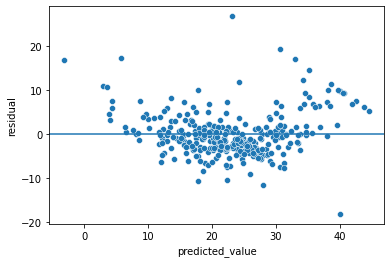

In [ ]:
# calculate residuals
residual = y_medv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

### Training Eror

In [ ]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_medv_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_medv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_medv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_medv_train, y_predict_train)))

RMSE for training data is 4.970317911815452
MAE for training data is 3.5232649104688907
MAPE for training data is 0.17456746260446843


### Test Eror

In [ ]:
# prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = ridge_best.predict(X_medv_test)

# ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_medv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_medv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_medv_test, y_predict_test)))

RMSE for testing data is 5.451611035479787
MAE for testing data is 3.3793880203602247
MAPE for testing data is 0.18221588882530718


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_error(y_medv_test, y_predict_test)
mean_absolute_percentage_error(y_medv_test, y_predict_test)

0.18221588882530718